![image1.png](image1.png)
![image.png](image.png)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, Dropout, Dense, Flatten
from keras.regularizers import l2
from utils import INPUT_SHAPE, batch_generator

(array([5.000e+00, 1.200e+01, 1.090e+02, 7.430e+02, 2.118e+03, 6.894e+03,
        1.470e+02, 6.300e+01, 2.400e+01, 6.000e+00]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

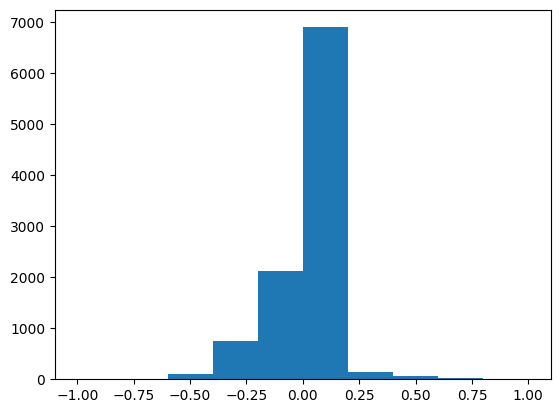

In [2]:
# Thư mục để dữ liệu
data_dir = 'dataset'
# Đọc file driving_log.csv với các cột tương ứng
data_df = pd.read_csv(os.path.join(os.getcwd(), data_dir, 'driving_log.csv'), names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

# Lấy đường dẫn đến ảnh ở camera giữa, trái, phải
X = data_df[['center', 'left', 'right']].values
# Lấy góc lái của ô tô
y = data_df['steering'].values

# Vẽ histogram dữ liệu
plt.hist(y)

Do quá nhiều dữ liệu với góc lái ở 0 tức là để ô tô đi thẳng, nên ta sẽ loại bỏ bớt đi để tránh việc model có xu hướng dự đoán góc lái thiên về 0.

(array([   5.,   12.,  109.,  743., 2118., 1410.,  147.,   63.,   24.,
           6.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

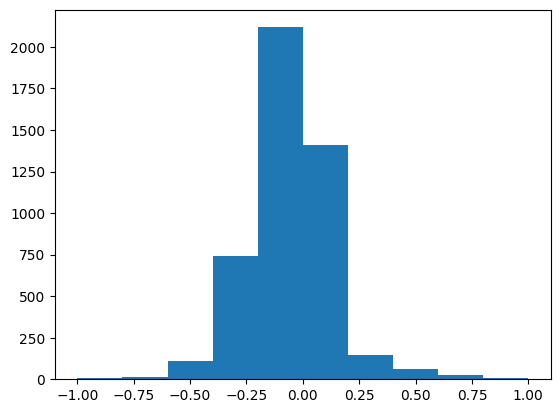

In [3]:
# Loại bỏ và chỉ lấy 1000 dữ liệu có góc lái ở 0
pos_zero = np.array(np.where(y==0)).reshape(-1, 1)
pos_none_zero = np.array(np.where(y!=0)).reshape(-1, 1)
np.random.shuffle(pos_zero)
pos_zero = pos_zero[:1000]

pos_combined = np.vstack((pos_zero, pos_none_zero))
pos_combined = list(pos_combined)

y = y[pos_combined].reshape(len(pos_combined))
X = X[pos_combined, :].reshape((len(pos_combined), 3))

# After process
plt.hist(y)

Ta vẫn để giá trị góc lái ở 0 là nhiều nhất vì có thể phần nhiều thời gian của ô tô là đi thẳng thật. Việc histogram lệch bên trái không quá quan trọng vì ta dùng flip ảnh.

In [4]:
# Chia ra traing set và validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
# Xây dựng model
model = Sequential()
model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=INPUT_SHAPE))
model.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 66, 200, 3)        0         
                                                                 
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)        

In [11]:
nb_epoch = 10
samples_per_epoch = 1000
batch_size = 32
save_best_only = True
learning_rate = 1e-4

# Checkpoint này để nói cho model lưu lại model nếu validation loss thấp nhất
checkpoint = ModelCheckpoint('models/model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=save_best_only,
                                 mode='auto')

# Dùng mean_squrared_error làm loss function
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))

# Train model
H = model.fit(batch_generator(data_dir, X_train, y_train, batch_size, True),
                    steps_per_epoch = samples_per_epoch,
                    epochs = nb_epoch,
                    validation_data=batch_generator(data_dir, X_valid, y_valid, batch_size, False),
                    validation_steps=len(X_valid),
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/10
1000/1000 [==============================] - 263s 258ms/step - loss: 0.0537 - val_loss: 0.0202
Epoch 2/10


C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000/1000 [==============================] - 256s 256ms/step - loss: 0.0403 - val_loss: 0.0169
Epoch 3/10
1000/1000 [==============================] - 256s 256ms/step - loss: 0.0373 - val_loss: 0.0160
Epoch 4/10
1000/1000 [==============================] - 246s 246ms/step - loss: 0.0344 - val_loss: 0.0158
Epoch 5/10
1000/1000 [==============================] - 238s 238ms/step - loss: 0.0336 - val_loss: 0.0160
Epoch 6/10
1000/1000 [==============================] - 242s 242ms/step - loss: 0.0327 - val_loss: 0.0156
Epoch 7/10
1000/1000 [==============================] - 245s 245ms/step - loss: 0.0317 - val_loss: 0.0159
Epoch 8/10
1000/1000 [==============================] - 230s 230ms/step - loss: 0.0304 - val_loss: 0.0151
Epoch 9/10
1000/1000 [==============================] - 221s 222ms/step - loss: 0.0298 - val_loss: 0.0156
Epoch 10/10
1000/1000 [==============================] - 219s 219ms/step - loss: 0.0290 - val_loss: 0.0152


Vậy model ở epoch 8 có val_loss thấp nhất nên ta sẽ dùng model này để cho ô tô tự lái